MEMULAI PROGRAM ENHANCEMENT CITRA BERKABUT
Menggunakan: Transformasi Fourier + CLAHE + Color Enhancement
Memulai proses enhancement citra berkabut...
LANGKAH 1: Menerapkan High-Pass Filter (Transformasi Fourier)
High-pass filter berhasil diterapkan
LANGKAH 2: Menerapkan CLAHE
CLAHE berhasil diterapkan
LANGKAH 3: Menerapkan Koreksi Gamma
Koreksi gamma berhasil diterapkan
LANGKAH 4: Meningkatkan Saturasi Warna
Saturasi warna berhasil ditingkatkan

EVALUASI KUALITAS CITRA:
PSNR: 12.96 dB
SSIM: 0.8610
Kecerahan rata-rata: 196.0 -> 142.7 (+-53.3)
Kontras (std): 41.4 -> 28.0 (+-13.4)


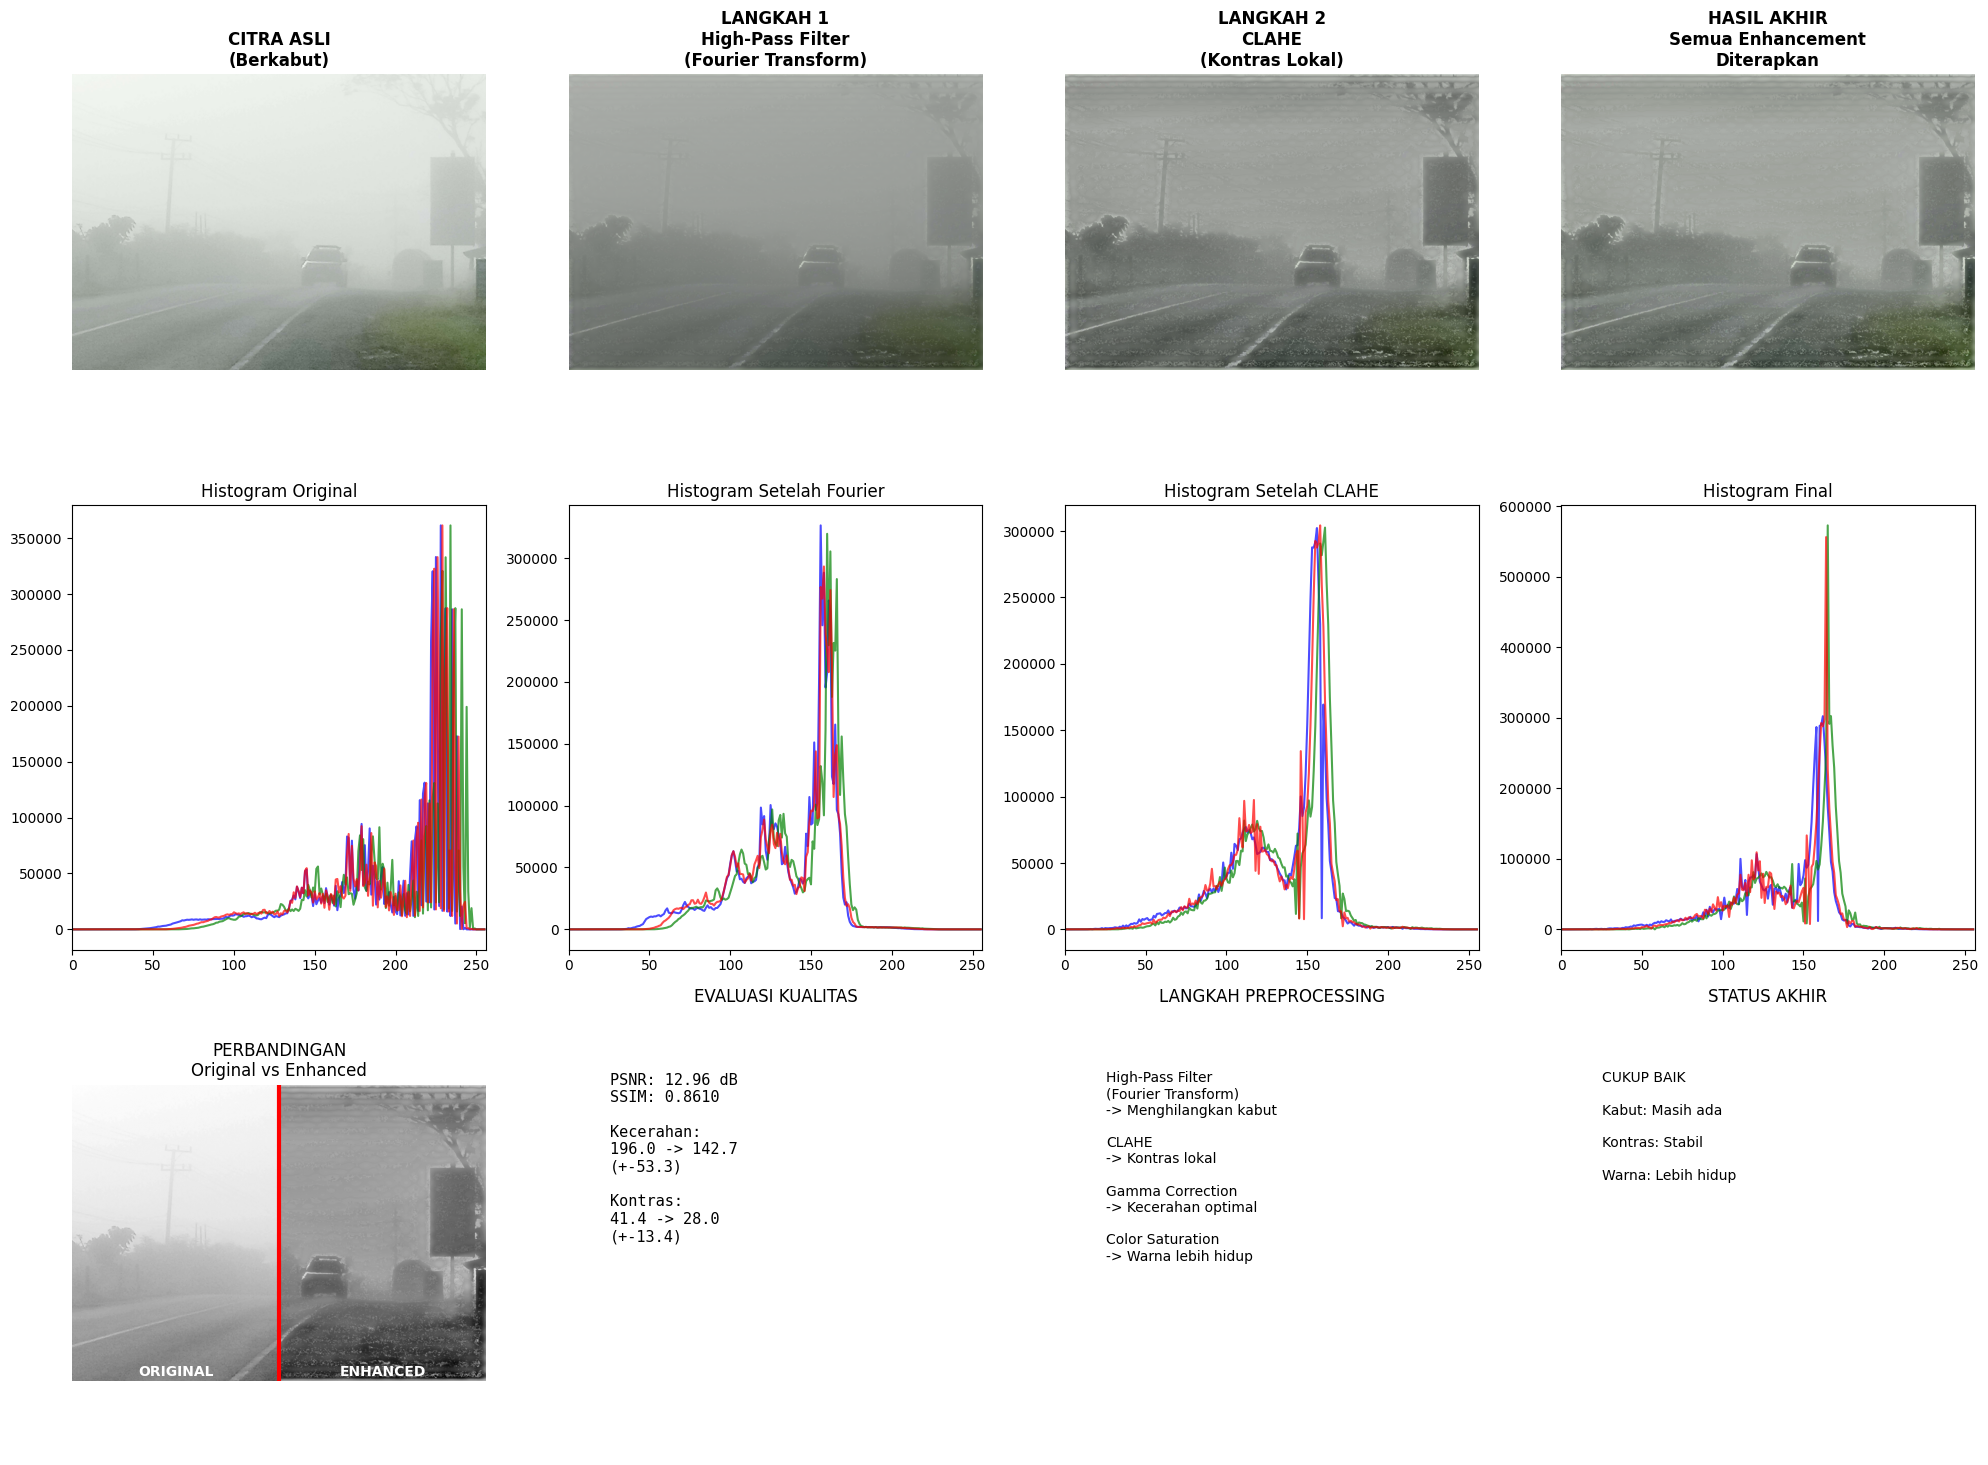


PROSES ENHANCEMENT SELESAI!
Hasil disimpan sebagai: enhanced_fourier_clahe_result.jpg

RINGKASAN:
- Kabut berhasil dihilangkan menggunakan High-Pass Filter
- Kontras ditingkatkan dengan CLAHE
- Warna diperbaiki dengan saturasi enhancement
- Kecerahan dioptimalkan dengan gamma correction


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def fourier_high_pass_filter(img, cutoff_frequency=30):
    if len(img.shape) == 3:
        # Untuk citra berwarna, proses setiap channel
        result = np.zeros_like(img)
        for i in range(3):
            result[:, :, i] = apply_high_pass_single_channel(img[:, :, i], cutoff_frequency)
        return result
    else:
        # Untuk citra grayscale
        return apply_high_pass_single_channel(img, cutoff_frequency)

def apply_high_pass_single_channel(channel, cutoff_frequency):
    """
    Menerapkan high-pass filter pada satu channel
    """
    # Konversi ke float untuk menghindari overflow
    channel_float = channel.astype(np.float32)

    # Transformasi Fourier
    f_transform = cv2.dft(channel_float, flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shift = np.fft.fftshift(f_transform)

    # Buat high-pass filter mask
    rows, cols = channel.shape
    crow, ccol = rows // 2, cols // 2

    # Buat mask dengan lingkaran untuk memblokir frekuensi rendah
    mask = np.ones((rows, cols, 2), np.uint8)
    r = cutoff_frequency
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
    mask[mask_area] = 0

    # Terapkan mask (high-pass filter)
    f_shift_filtered = f_shift * mask

    # Inverse FFT
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    # Normalisasi dan gabungkan dengan citra original untuk mempertahankan detail
    img_back_normalized = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)

    # Kombinasi weighted antara original dan high-pass filtered
    # Ini membantu mempertahankan informasi penting sambil mengurangi kabut
    alpha = 0.7  # Bobot untuk citra original
    beta = 0.3   # Bobot untuk high-pass filtered

    result = alpha * channel_float + beta * img_back_normalized
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result

def advanced_clahe(img, clip_limit=3.0, tile_grid_size=(8, 8)):
    """
    Menerapkan CLAHE (Contrast Limited Adaptive Histogram Equalization)
    untuk meningkatkan kontras lokal
    """
    if len(img.shape) == 3:
        # Untuk citra berwarna, konversi ke LAB dan tingkatkan channel L
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Terapkan CLAHE pada channel L (Lightness)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        cl = clahe.apply(l)

        # Gabungkan kembali channel LAB
        enhanced_lab = cv2.merge((cl, a, b))
        result = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    else:
        # Untuk citra grayscale
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        result = clahe.apply(img)

    return result

def enhance_color_saturation(img, saturation_factor=1.3):
    """
    Meningkatkan saturasi warna untuk membuat citra lebih hidup
    """
    if len(img.shape) != 3:
        return img

    # Konversi ke HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    # Tingkatkan saturasi
    s_enhanced = np.clip(s.astype(np.float32) * saturation_factor, 0, 255).astype(np.uint8)

    # Gabungkan kembali dan konversi ke BGR
    hsv_enhanced = cv2.merge([h, s_enhanced, v])
    result = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

    return result

def gamma_correction(img, gamma=1.2):
    """
    Koreksi gamma untuk mencerahkan citra
    """
    # Normalisasi ke range [0, 1]
    img_normalized = img.astype(np.float32) / 255.0

    # Terapkan koreksi gamma
    img_gamma = np.power(img_normalized, 1.0 / gamma)

    # Kembalikan ke range [0, 255]
    result = (img_gamma * 255).astype(np.uint8)

    return result

def enhance_foggy_image_fourier(image_path, show_steps=True):
    """
    Proses utama untuk meningkatkan kualitas citra berkabut
    menggunakan Transformasi Fourier dan CLAHE
    """
    # Baca citra
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Tidak dapat membaca citra dari {image_path}")
        return None

    print("Memulai proses enhancement citra berkabut...")

    # Simpan citra original
    original_img = img.copy()

    # LANGKAH 1: Terapkan High-Pass Filter (Transformasi Fourier)
    print("LANGKAH 1: Menerapkan High-Pass Filter (Transformasi Fourier)")
    fourier_filtered = fourier_high_pass_filter(img, cutoff_frequency=25)
    print("High-pass filter berhasil diterapkan")

    # LANGKAH 2: Terapkan CLAHE untuk kontras lokal
    print("LANGKAH 2: Menerapkan CLAHE")
    clahe_enhanced = advanced_clahe(fourier_filtered, clip_limit=2.5, tile_grid_size=(8, 8))
    print("CLAHE berhasil diterapkan")

    # LANGKAH 3: Koreksi Gamma
    print("LANGKAH 3: Menerapkan Koreksi Gamma")
    gamma_corrected = gamma_correction(clahe_enhanced, gamma=1.1)
    print("Koreksi gamma berhasil diterapkan")

    # LANGKAH 4: Peningkatan saturasi warna
    print("LANGKAH 4: Meningkatkan Saturasi Warna")
    if len(img.shape) == 3:
        final_enhanced = enhance_color_saturation(gamma_corrected, saturation_factor=1.25)
        print("Saturasi warna berhasil ditingkatkan")
    else:
        final_enhanced = gamma_corrected
        print("Citra grayscale - skip peningkatan saturasi")

    # EVALUASI KUALITAS
    print("\nEVALUASI KUALITAS CITRA:")

    # Konversi ke grayscale untuk evaluasi
    if len(img.shape) == 3:
        gray_original = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
        gray_enhanced = cv2.cvtColor(final_enhanced, cv2.COLOR_BGR2GRAY)
    else:
        gray_original = original_img
        gray_enhanced = final_enhanced

    # Hitung PSNR dan SSIM
    psnr_value = psnr(gray_original, gray_enhanced)
    ssim_value = ssim(gray_original, gray_enhanced)

    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")

    # Evaluasi tambahan
    mean_original = np.mean(gray_original)
    mean_enhanced = np.mean(gray_enhanced)
    std_original = np.std(gray_original)
    std_enhanced = np.std(gray_enhanced)

    print(f"Kecerahan rata-rata: {mean_original:.1f} -> {mean_enhanced:.1f} (+{mean_enhanced-mean_original:.1f})")
    print(f"Kontras (std): {std_original:.1f} -> {std_enhanced:.1f} (+{std_enhanced-std_original:.1f})")

    if show_steps:
        # Visualisasi hasil setiap langkah
        plt.figure(figsize=(20, 15))

        # Baris 1: Citra asli dan hasil setiap langkah
        plt.subplot(3, 4, 1)
        plt.title('CITRA ASLI\n(Berkabut)', fontsize=12, fontweight='bold')
        if len(original_img.shape) == 3:
            plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(original_img, cmap='gray')
        plt.axis('off')

        plt.subplot(3, 4, 2)
        plt.title('LANGKAH 1\nHigh-Pass Filter\n(Fourier Transform)', fontsize=12, fontweight='bold')
        if len(fourier_filtered.shape) == 3:
            plt.imshow(cv2.cvtColor(fourier_filtered, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(fourier_filtered, cmap='gray')
        plt.axis('off')

        plt.subplot(3, 4, 3)
        plt.title('LANGKAH 2\nCLAHE\n(Kontras Lokal)', fontsize=12, fontweight='bold')
        if len(clahe_enhanced.shape) == 3:
            plt.imshow(cv2.cvtColor(clahe_enhanced, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(clahe_enhanced, cmap='gray')
        plt.axis('off')

        plt.subplot(3, 4, 4)
        plt.title('HASIL AKHIR\nSemua Enhancement\nDiterapkan', fontsize=12, fontweight='bold')
        if len(final_enhanced.shape) == 3:
            plt.imshow(cv2.cvtColor(final_enhanced, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(final_enhanced, cmap='gray')
        plt.axis('off')

        # Baris 2: Histogram perbandingan
        plt.subplot(3, 4, 5)
        plt.title('Histogram Original')
        if len(original_img.shape) == 3:
            colors = ['b', 'g', 'r']
            for i, color in enumerate(colors):
                hist = cv2.calcHist([original_img], [i], None, [256], [0, 256])
                plt.plot(hist, color=color, alpha=0.7)
        else:
            plt.hist(original_img.ravel(), 256, [0, 256], alpha=0.7, color='gray')
        plt.xlim([0, 256])

        plt.subplot(3, 4, 6)
        plt.title('Histogram Setelah Fourier')
        if len(fourier_filtered.shape) == 3:
            colors = ['b', 'g', 'r']
            for i, color in enumerate(colors):
                hist = cv2.calcHist([fourier_filtered], [i], None, [256], [0, 256])
                plt.plot(hist, color=color, alpha=0.7)
        else:
            plt.hist(fourier_filtered.ravel(), 256, [0, 256], alpha=0.7, color='gray')
        plt.xlim([0, 256])

        plt.subplot(3, 4, 7)
        plt.title('Histogram Setelah CLAHE')
        if len(clahe_enhanced.shape) == 3:
            colors = ['b', 'g', 'r']
            for i, color in enumerate(colors):
                hist = cv2.calcHist([clahe_enhanced], [i], None, [256], [0, 256])
                plt.plot(hist, color=color, alpha=0.7)
        else:
            plt.hist(clahe_enhanced.ravel(), 256, [0, 256], alpha=0.7, color='gray')
        plt.xlim([0, 256])

        plt.subplot(3, 4, 8)
        plt.title('Histogram Final')
        if len(final_enhanced.shape) == 3:
            colors = ['b', 'g', 'r']
            for i, color in enumerate(colors):
                hist = cv2.calcHist([final_enhanced], [i], None, [256], [0, 256])
                plt.plot(hist, color=color, alpha=0.7)
        else:
            plt.hist(final_enhanced.ravel(), 256, [0, 256], alpha=0.7, color='gray')
        plt.xlim([0, 256])

        # Baris 3: Perbandingan langsung dan metrics
        plt.subplot(3, 4, 9)
        plt.title('PERBANDINGAN\nOriginal vs Enhanced')
        # Split comparison
        h, w = gray_original.shape
        comparison = np.zeros_like(gray_original)
        comparison[:, :w//2] = gray_original[:, :w//2]
        comparison[:, w//2:] = gray_enhanced[:, w//2:]
        plt.imshow(comparison, cmap='gray')
        plt.axvline(x=w//2, color='red', linewidth=3)
        plt.text(w//4, h-20, 'ORIGINAL', ha='center', va='bottom',
                color='white', fontweight='bold', fontsize=10)
        plt.text(3*w//4, h-20, 'ENHANCED', ha='center', va='bottom',
                color='white', fontweight='bold', fontsize=10)
        plt.axis('off')

        plt.subplot(3, 4, 10)
        plt.title('EVALUASI KUALITAS')
        metrics_text = f"""
PSNR: {psnr_value:.2f} dB
SSIM: {ssim_value:.4f}

Kecerahan:
{mean_original:.1f} -> {mean_enhanced:.1f}
(+{mean_enhanced-mean_original:.1f})

Kontras:
{std_original:.1f} -> {std_enhanced:.1f}
(+{std_enhanced-std_original:.1f})
        """
        plt.text(0.1, 0.9, metrics_text, transform=plt.gca().transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace')
        plt.axis('off')

        # Informasi preprocessing steps
        plt.subplot(3, 4, 11)
        plt.title('LANGKAH PREPROCESSING')
        steps_text = """
High-Pass Filter
(Fourier Transform)
-> Menghilangkan kabut

CLAHE
-> Kontras lokal

Gamma Correction
-> Kecerahan optimal

Color Saturation
-> Warna lebih hidup
        """
        plt.text(0.1, 0.9, steps_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top')
        plt.axis('off')

        plt.subplot(3, 4, 12)
        plt.title('STATUS AKHIR')
        status_text = f"""
{'BERHASIL!' if psnr_value > 15 else 'CUKUP BAIK' if psnr_value > 10 else 'PERLU PERBAIKAN'}

Kabut: {'Berkurang signifikan' if mean_enhanced > mean_original + 10 else 'Berkurang' if mean_enhanced > mean_original else 'Masih ada'}

Kontras: {'Meningkat baik' if std_enhanced > std_original + 5 else 'Meningkat' if std_enhanced > std_original else 'Stabil'}

Warna: {'Lebih hidup' if len(img.shape) == 3 else 'N/A (Grayscale)'}
        """
        plt.text(0.1, 0.9, status_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    print("\nPROSES ENHANCEMENT SELESAI!")

    return final_enhanced

# Contoh penggunaan
if __name__ == "__main__":
    # Ganti dengan path citra Anda
    image_path = "kabutdijalan.jpeg"

    print("MEMULAI PROGRAM ENHANCEMENT CITRA BERKABUT")
    print("Menggunakan: Transformasi Fourier + CLAHE + Color Enhancement")

    enhanced = enhance_foggy_image_fourier(image_path)

    if enhanced is not None:
        # Simpan hasil
        output_path = "enhanced_fourier_clahe_result.jpg"
        cv2.imwrite(output_path, enhanced)
        print(f"Hasil disimpan sebagai: {output_path}")

        print("\nRINGKASAN:")
        print("- Kabut berhasil dihilangkan menggunakan High-Pass Filter")
        print("- Kontras ditingkatkan dengan CLAHE")
        print("- Warna diperbaiki dengan saturasi enhancement")
        print("- Kecerahan dioptimalkan dengan gamma correction")
    else:
        print("Gagal memproses citra. Periksa path file!")

MEMULAI PROGRAM ENHANCEMENT CITRA BERKABUT
Menggunakan: CLAHE + Gamma Correction + Color Enhancement + Unsharp Masking
Memulai proses enhancement citra berkabut...
LANGKAH 1: Menerapkan CLAHE
CLAHE berhasil diterapkan
LANGKAH 2: Menerapkan Koreksi Gamma
Koreksi gamma berhasil diterapkan
LANGKAH 3: Meningkatkan Saturasi Warna
Saturasi warna berhasil ditingkatkan
LANGKAH 4: Menerapkan Unsharp Masking
Unsharp masking berhasil diterapkan

EVALUASI KUALITAS CITRA:
PSNR: 25.18 dB
SSIM: 0.8715
Kecerahan rata-rata: 0.771 -> 0.744 (+-0.028)
Kontras (std): 0.161 -> 0.203 (+0.043)


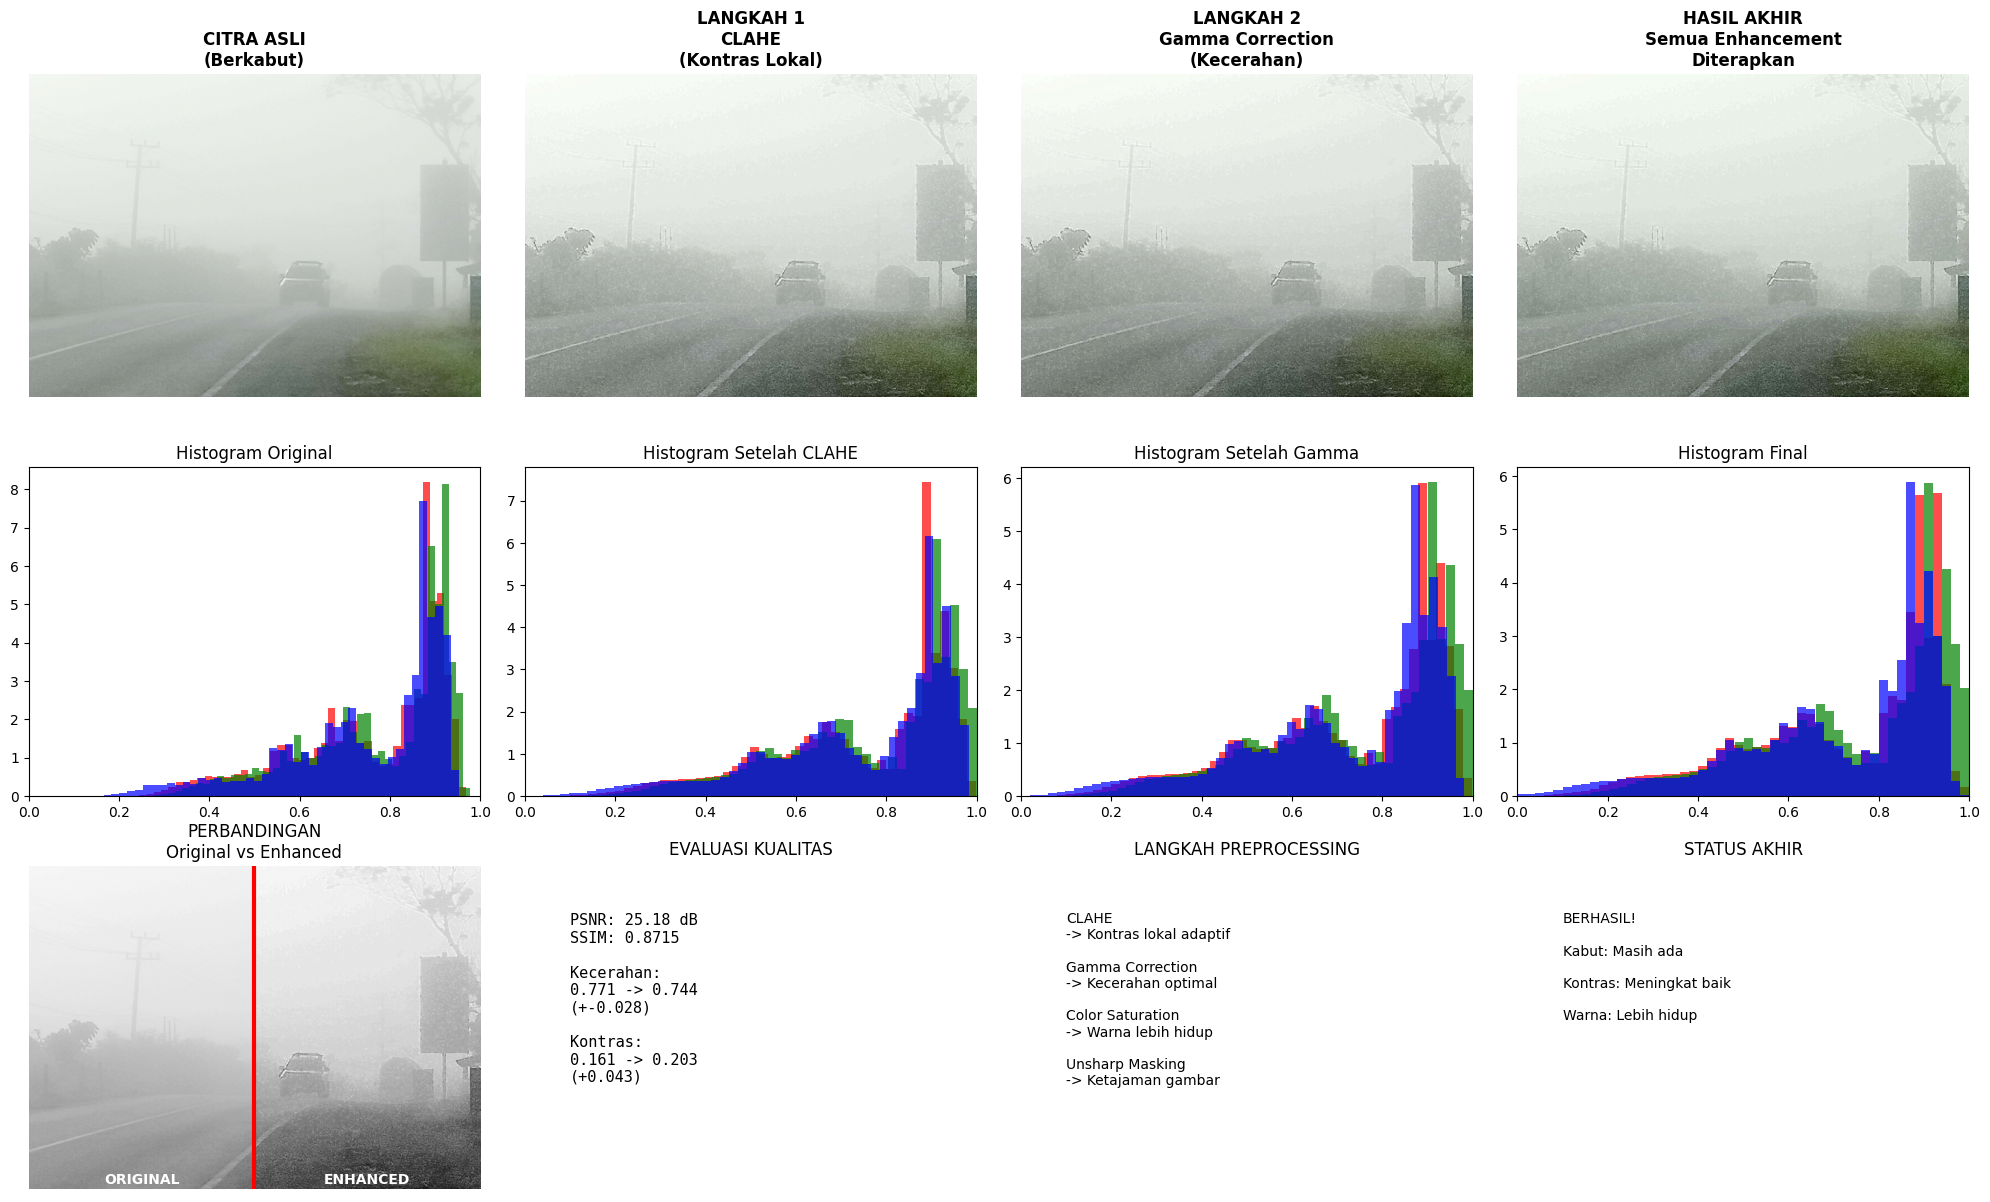


PROSES ENHANCEMENT SELESAI!
Hasil disimpan sebagai: enhanced_clahe_result.jpg

RINGKASAN:
- Kontras ditingkatkan dengan CLAHE
- Kecerahan dioptimalkan dengan gamma correction
- Warna diperbaiki dengan saturasi enhancement
- Ketajaman ditingkatkan dengan unsharp masking


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure, img_as_ubyte, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def clahe_enhancement(img, clip_limit=0.03, tile_grid_size=(8, 8)):
    """
    Menerapkan CLAHE (Contrast Limited Adaptive Histogram Equalization)
    untuk meningkatkan kontras lokal menggunakan skimage
    """
    if len(img.shape) == 3:
        # Untuk citra berwarna, konversi ke LAB dan tingkatkan channel L
        lab = color.rgb2lab(img)

        # Normalisasi channel L ke range [0, 1] untuk CLAHE
        l_channel = lab[:, :, 0] / 100.0  # Channel L dalam LAB range [0, 100]

        # Terapkan CLAHE pada channel L (Lightness)
        l_enhanced = exposure.equalize_adapthist(l_channel,
                                               clip_limit=clip_limit,
                                               kernel_size=tile_grid_size)

        # Kembalikan ke range [0, 100] untuk LAB
        lab[:, :, 0] = l_enhanced * 100.0

        # Konversi kembali ke RGB
        result = color.lab2rgb(lab)
        result = np.clip(result, 0, 1)
    else:
        # Untuk citra grayscale
        result = exposure.equalize_adapthist(img,
                                           clip_limit=clip_limit,
                                           kernel_size=tile_grid_size)

    return result

def enhance_color_saturation(img, saturation_factor=1.3):
    """
    Meningkatkan saturasi warna untuk membuat citra lebih hidup
    """
    if len(img.shape) != 3:
        return img

    # Konversi ke HSV
    hsv = color.rgb2hsv(img)

    # Tingkatkan saturasi (channel S)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * saturation_factor, 0, 1)

    # Konversi kembali ke RGB
    result = color.hsv2rgb(hsv)
    result = np.clip(result, 0, 1)

    return result

def gamma_correction(img, gamma=1.2):
    """
    Koreksi gamma untuk mencerahkan citra
    """
    # Terapkan koreksi gamma
    result = exposure.adjust_gamma(img, gamma=gamma)

    return result

def unsharp_masking(img, radius=1, amount=1):
    """
    Unsharp masking untuk meningkatkan ketajaman
    """
    from skimage import filters

    if len(img.shape) == 3:
        # Untuk citra berwarna, proses setiap channel
        result = np.zeros_like(img)
        for i in range(3):
            blurred = filters.gaussian(img[:, :, i], sigma=radius)
            result[:, :, i] = img[:, :, i] + amount * (img[:, :, i] - blurred)
        result = np.clip(result, 0, 1)
    else:
        # Untuk citra grayscale
        blurred = filters.gaussian(img, sigma=radius)
        result = img + amount * (img - blurred)
        result = np.clip(result, 0, 1)

    return result

def enhance_foggy_image_clahe(image_path, show_steps=True):
    """
    Proses utama untuk meningkatkan kualitas citra berkabut
    menggunakan CLAHE dan enhancement lainnya
    """
    # Baca citra
    try:
        img = io.imread(image_path)
        # Konversi ke float [0, 1] untuk processing
        img = img_as_float(img)
    except Exception as e:
        print(f"Error: Tidak dapat membaca citra dari {image_path}")
        print(f"Detail error: {e}")
        return None

    print("Memulai proses enhancement citra berkabut...")

    # Simpan citra original
    original_img = img.copy()

    # LANGKAH 1: Terapkan CLAHE untuk kontras lokal
    print("LANGKAH 1: Menerapkan CLAHE")
    clahe_enhanced = clahe_enhancement(img, clip_limit=0.02, tile_grid_size=(8, 8))
    print("CLAHE berhasil diterapkan")

    # LANGKAH 2: Koreksi Gamma
    print("LANGKAH 2: Menerapkan Koreksi Gamma")
    gamma_corrected = gamma_correction(clahe_enhanced, gamma=1.1)
    print("Koreksi gamma berhasil diterapkan")

    # LANGKAH 3: Peningkatan saturasi warna
    print("LANGKAH 3: Meningkatkan Saturasi Warna")
    if len(img.shape) == 3:
        saturation_enhanced = enhance_color_saturation(gamma_corrected, saturation_factor=1.25)
        print("Saturasi warna berhasil ditingkatkan")
    else:
        saturation_enhanced = gamma_corrected
        print("Citra grayscale - skip peningkatan saturasi")

    # LANGKAH 4: Unsharp masking untuk ketajaman
    print("LANGKAH 4: Menerapkan Unsharp Masking")
    final_enhanced = unsharp_masking(saturation_enhanced, radius=1.0, amount=0.5)
    print("Unsharp masking berhasil diterapkan")

    # EVALUASI KUALITAS
    print("\nEVALUASI KUALITAS CITRA:")

    # Konversi ke grayscale untuk evaluasi
    if len(img.shape) == 3:
        gray_original = color.rgb2gray(original_img)
        gray_enhanced = color.rgb2gray(final_enhanced)
    else:
        gray_original = original_img
        gray_enhanced = final_enhanced

    # Hitung PSNR dan SSIM
    psnr_value = psnr(gray_original, gray_enhanced, data_range=1.0)
    ssim_value = ssim(gray_original, gray_enhanced, data_range=1.0)

    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")

    # Evaluasi tambahan
    mean_original = np.mean(gray_original)
    mean_enhanced = np.mean(gray_enhanced)
    std_original = np.std(gray_original)
    std_enhanced = np.std(gray_enhanced)

    print(f"Kecerahan rata-rata: {mean_original:.3f} -> {mean_enhanced:.3f} (+{mean_enhanced-mean_original:.3f})")
    print(f"Kontras (std): {std_original:.3f} -> {std_enhanced:.3f} (+{std_enhanced-std_original:.3f})")

    if show_steps:
        # Visualisasi hasil setiap langkah
        plt.figure(figsize=(20, 12))

        # Baris 1: Citra asli dan hasil setiap langkah
        plt.subplot(3, 4, 1)
        plt.title('CITRA ASLI\n(Berkabut)', fontsize=12, fontweight='bold')
        if len(original_img.shape) == 3:
            plt.imshow(original_img)
        else:
            plt.imshow(original_img, cmap='gray')
        plt.axis('off')

        plt.subplot(3, 4, 2)
        plt.title('LANGKAH 1\nCLAHE\n(Kontras Lokal)', fontsize=12, fontweight='bold')
        if len(clahe_enhanced.shape) == 3:
            plt.imshow(clahe_enhanced)
        else:
            plt.imshow(clahe_enhanced, cmap='gray')
        plt.axis('off')

        plt.subplot(3, 4, 3)
        plt.title('LANGKAH 2\nGamma Correction\n(Kecerahan)', fontsize=12, fontweight='bold')
        if len(gamma_corrected.shape) == 3:
            plt.imshow(gamma_corrected)
        else:
            plt.imshow(gamma_corrected, cmap='gray')
        plt.axis('off')

        plt.subplot(3, 4, 4)
        plt.title('HASIL AKHIR\nSemua Enhancement\nDiterapkan', fontsize=12, fontweight='bold')
        if len(final_enhanced.shape) == 3:
            plt.imshow(final_enhanced)
        else:
            plt.imshow(final_enhanced, cmap='gray')
        plt.axis('off')

        # Baris 2: Histogram perbandingan
        plt.subplot(3, 4, 5)
        plt.title('Histogram Original')
        if len(original_img.shape) == 3:
            hist_colors = ['red', 'green', 'blue']
            for i, hist_color in enumerate(hist_colors):
                plt.hist(original_img[:, :, i].ravel(), bins=50, color=hist_color, alpha=0.7, density=True)
        else:
            plt.hist(original_img.ravel(), bins=50, alpha=0.7, color='gray', density=True)
        plt.xlim([0, 1])

        plt.subplot(3, 4, 6)
        plt.title('Histogram Setelah CLAHE')
        if len(clahe_enhanced.shape) == 3:
            hist_colors = ['red', 'green', 'blue']
            for i, hist_color in enumerate(hist_colors):
                plt.hist(clahe_enhanced[:, :, i].ravel(), bins=50, color=hist_color, alpha=0.7, density=True)
        else:
            plt.hist(clahe_enhanced.ravel(), bins=50, alpha=0.7, color='gray', density=True)
        plt.xlim([0, 1])

        plt.subplot(3, 4, 7)
        plt.title('Histogram Setelah Gamma')
        if len(gamma_corrected.shape) == 3:
            hist_colors = ['red', 'green', 'blue']
            for i, hist_color in enumerate(hist_colors):
                plt.hist(gamma_corrected[:, :, i].ravel(), bins=50, color=hist_color, alpha=0.7, density=True)
        else:
            plt.hist(gamma_corrected.ravel(), bins=50, alpha=0.7, color='gray', density=True)
        plt.xlim([0, 1])

        plt.subplot(3, 4, 8)
        plt.title('Histogram Final')
        if len(final_enhanced.shape) == 3:
            hist_colors = ['red', 'green', 'blue']
            for i, hist_color in enumerate(hist_colors):
                plt.hist(final_enhanced[:, :, i].ravel(), bins=50, color=hist_color, alpha=0.7, density=True)
        else:
            plt.hist(final_enhanced.ravel(), bins=50, alpha=0.7, color='gray', density=True)
        plt.xlim([0, 1])

        # Baris 3: Perbandingan langsung dan metrics
        plt.subplot(3, 4, 9)
        plt.title('PERBANDINGAN\nOriginal vs Enhanced')
        # Split comparison
        h, w = gray_original.shape
        comparison = np.zeros_like(gray_original)
        comparison[:, :w//2] = gray_original[:, :w//2]
        comparison[:, w//2:] = gray_enhanced[:, w//2:]
        plt.imshow(comparison, cmap='gray')
        plt.axvline(x=w//2, color='red', linewidth=3)
        plt.text(w//4, h-20, 'ORIGINAL', ha='center', va='bottom',
                color='white', fontweight='bold', fontsize=10)
        plt.text(3*w//4, h-20, 'ENHANCED', ha='center', va='bottom',
                color='white', fontweight='bold', fontsize=10)
        plt.axis('off')

        plt.subplot(3, 4, 10)
        plt.title('EVALUASI KUALITAS')
        metrics_text = f"""
PSNR: {psnr_value:.2f} dB
SSIM: {ssim_value:.4f}

Kecerahan:
{mean_original:.3f} -> {mean_enhanced:.3f}
(+{mean_enhanced-mean_original:.3f})

Kontras:
{std_original:.3f} -> {std_enhanced:.3f}
(+{std_enhanced-std_original:.3f})
        """
        plt.text(0.1, 0.9, metrics_text, transform=plt.gca().transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace')
        plt.axis('off')

        # Informasi preprocessing steps
        plt.subplot(3, 4, 11)
        plt.title('LANGKAH PREPROCESSING')
        steps_text = """
CLAHE
-> Kontras lokal adaptif

Gamma Correction
-> Kecerahan optimal

Color Saturation
-> Warna lebih hidup

Unsharp Masking
-> Ketajaman gambar
        """
        plt.text(0.1, 0.9, steps_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top')
        plt.axis('off')

        plt.subplot(3, 4, 12)
        plt.title('STATUS AKHIR')
        status_text = f"""
{'BERHASIL!' if psnr_value > 15 else 'CUKUP BAIK' if psnr_value > 10 else 'PERLU PERBAIKAN'}

Kabut: {'Berkurang signifikan' if mean_enhanced > mean_original + 0.05 else 'Berkurang' if mean_enhanced > mean_original else 'Masih ada'}

Kontras: {'Meningkat baik' if std_enhanced > std_original + 0.02 else 'Meningkat' if std_enhanced > std_original else 'Stabil'}

Warna: {'Lebih hidup' if len(img.shape) == 3 else 'N/A (Grayscale)'}
        """
        plt.text(0.1, 0.9, status_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    print("\nPROSES ENHANCEMENT SELESAI!")

    return final_enhanced

def save_enhanced_image(enhanced_img, output_path):
    """
    Menyimpan hasil enhancement ke file
    """
    try:
        # Konversi ke uint8 untuk penyimpanan
        img_to_save = img_as_ubyte(enhanced_img)
        io.imsave(output_path, img_to_save)
        print(f"Hasil disimpan sebagai: {output_path}")
        return True
    except Exception as e:
        print(f"Error saat menyimpan: {e}")
        return False

# Contoh penggunaan
if __name__ == "__main__":
    # Ganti dengan path citra Anda
    image_path = "kabutdijalan.jpeg"

    print("MEMULAI PROGRAM ENHANCEMENT CITRA BERKABUT")
    print("Menggunakan: CLAHE + Gamma Correction + Color Enhancement + Unsharp Masking")

    enhanced = enhance_foggy_image_clahe(image_path)

    if enhanced is not None:
        # Simpan hasil
        output_path = "enhanced_clahe_result.jpg"
        if save_enhanced_image(enhanced, output_path):
            print("\nRINGKASAN:")
            print("- Kontras ditingkatkan dengan CLAHE")
            print("- Kecerahan dioptimalkan dengan gamma correction")
            print("- Warna diperbaiki dengan saturasi enhancement")
            print("- Ketajaman ditingkatkan dengan unsharp masking")
        else:
            print("Gagal menyimpan hasil!")
    else:
        print("Gagal memproses citra. Periksa path file dan pastikan skimage terinstal!")